In [24]:
#from google.colab import drive
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt



In [25]:
#drive.mount('/content/drive')
file_path = "/kaggle/input/faces-dataset/faces_dataset"
width = height = 160


In [26]:
# Function to load images and labels
def load_images_and_labels(train_path, width, height):
    x_train = []
    y_train = []

    # Iterate through each folder (class) in the training path
    for folder_name in os.listdir(train_path):
        folder_path = os.path.join(train_path, folder_name)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Iterate through each image in the folder
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)

                # Load the image and resize it to your desired size
                img = image.load_img(img_path, target_size=(width, height))  # تغيير الاستيراد هنا
                img_array = image.img_to_array(img)  # تغيير الاستيراد هنا

                # Append the image array to x_train
                x_train.append(img_array)

                # Append the label (folder name) to y_train
                y_train.append(folder_name)

    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    return np.array(x_train), np.array(y_train_encoded)

In [27]:
x, y = load_images_and_labels(file_path, width, height)

In [150]:
import matplotlib.pyplot as plt

# Function to plot a sample from each class
def plot_sample_images(x_data, y_data, class_names, title):
    num_classes = len(class_names)

    # Create a figure with subplots for each class
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 3))

    # Set the title for the entire figure
    fig.suptitle(title, fontsize=16)

    for i, class_name in enumerate(class_names):
        # Find the indices of images belonging to the current class
        class_indices = np.where(y_data == class_name)[0]

        if len(class_indices) > 0:
            sample_index = class_indices[3]
            sample_img = x_data[sample_index]
            label = y_data[sample_index]

            # Plot the image
            axs[i].imshow(sample_img.astype(np.uint8))
            axs[i].axis('off')
            axs[i].set_title(class_names[label])
    plt.show()


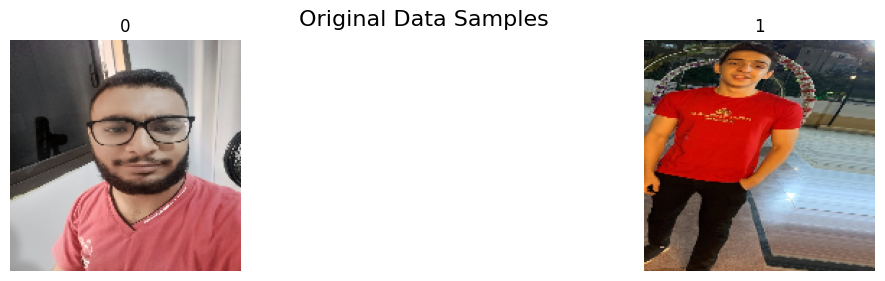

In [49]:
# Get unique class names
class_names = np.unique(y)
# Plot a sample from each class
plot_sample_images(x, y, class_names, title='Original Data Samples')


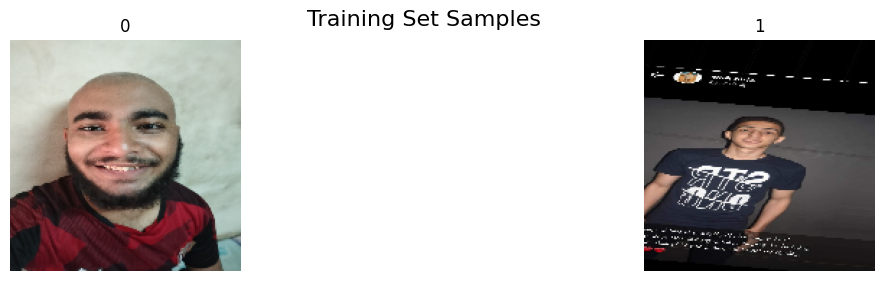

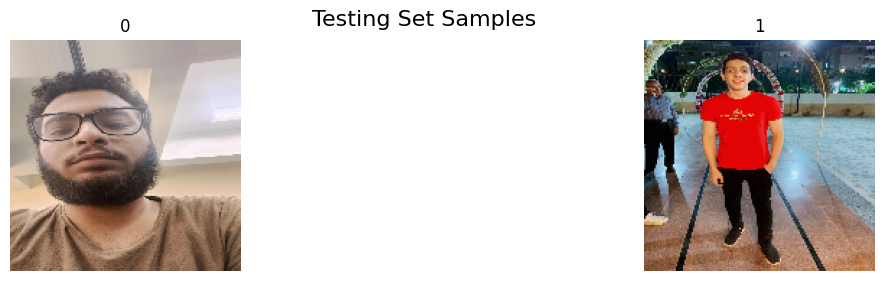

(408, 160, 160, 3)

In [71]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Plot a sample from each class for the training set
class_names = np.unique(y_train)
plot_sample_images(x_train, y_train, class_names, title='Training Set Samples')

# Plot a sample from each class for the testing set
class_names = np.unique(y_test)
plot_sample_images(x_test, y_test, class_names, title='Testing Set Samples')



In [32]:
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0



In [33]:
# Encoder architecture
def build_encoder(input_shape, latent_dim):
    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)  # Latent mean
    z_mean = layers.Dense(latent_dim)(x)
    x = layers.Dense(512, activation='relu')(x)  # Latent log variance
    z_log_var = layers.Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder


In [34]:
# Decoder architecture
def build_decoder(latent_dim, output_shape):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(40 * 40 * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((40, 40, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(output_shape[-1], 3, activation='tanh', padding='same')(x)

    decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder


In [35]:
# VAE architecture combining encoder and decoder
def build_vae(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim, input_shape)

    inputs = layers.Input(shape=input_shape)
    z_mean, z_log_var, z = encoder(inputs)
    reconstructed = decoder(z)

    vae = models.Model(inputs, reconstructed, name='vae')
    return vae


In [36]:
# Define new loss function suitable for image reconstruction
def custom_loss(y_true, y_pred):
    z_mean, z_log_var, z = vae.layers[1](y_true)  # Extracting z_mean, z_log_var, z from encoder
    reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]  # Scaling the loss
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    total_loss = reconstruction_loss + kl_loss
    return total_loss

In [148]:
# Example usage
input_shape = (160, 160, 3)  # Replace with your image shape
latent_dim = 1000  # Increase the latent dimensionality further
vae = build_vae(input_shape, latent_dim)
from keras.models import load_model

# Load weights from a file
weights_path = 'best_model_weights3.h5'
vae.load_weights(weights_path)
# Compile VAE with custom loss function
vae.compile(optimizer='adam', loss=custom_loss)

# Display VAE architecture summary
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 1000),            53737360  
                              (None, 1000),                      
                              (None, 1000)]                      
                                                                 
 decoder (Functional)        (None, 160, 160, 3)       102558659 
                                                                 
Total params: 156296019 (596.22 MB)
Trainable params: 156296019 (596.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [149]:
from keras.callbacks import ModelCheckpoint

# Assuming you have a model named 'model' and training data (X_train, y_train), validation data (X_val, y_val)

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    'best_model_weights4.h5',
    monitor='loss',  # Monitor training loss
    save_best_only=True,  # Save only the best weights
    mode='min',  # Save the weights when the monitored quantity is minimized (e.g., loss)
    verbose=1  # Print more information
)



# The best model weights will be saved to 'best_model_weights.h5' based on training loss
# Train the VAE model
vae.fit(x_train_normalized, x_train_normalized, epochs=100, batch_size=64, callbacks=[checkpoint] )


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 452.7026
Epoch 1: loss improved from inf to 452.70258, saving model to best_model_weights4.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 11s 313ms/step - loss: 452.7026
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 221.2546
Epoch 2: loss improved from 452.70258 to 221.25461, saving model to best_model_weights4.h5
26/26 [==============================] - 8s 315ms/step - loss: 221.2546
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 181.7693
Epoch 3: loss improved from 221.25461 to 181.76930, saving model to best_model_weights4.h5
26/26 [==============================] - 12s 455ms/step - loss: 181.7693
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 170.0988
Epoch 4: loss improved from 181.76930 to 170.09877, saving model to best_model_weights4.h5
26/26 [==============================] - 12s 488ms/step - loss: 170.0988
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 165.9227
Epoch 5: loss improved from 170.09877 to 165.92265, saving model to best_model_weights4.h5
26/26 [==========================

In [131]:
# Plot original and reconstructed images
def plot_comparison(original, reconstructed, num_samples=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Plot original images
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[i].astype('uint8'))
        plt.title("Original")
        plt.axis('off')

        # Plot reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow((reconstructed[i] * 255).astype('uint8'))  # Adjust pixel values back to 0-255 range
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

13/13 [==============================] - 1s 28ms/step


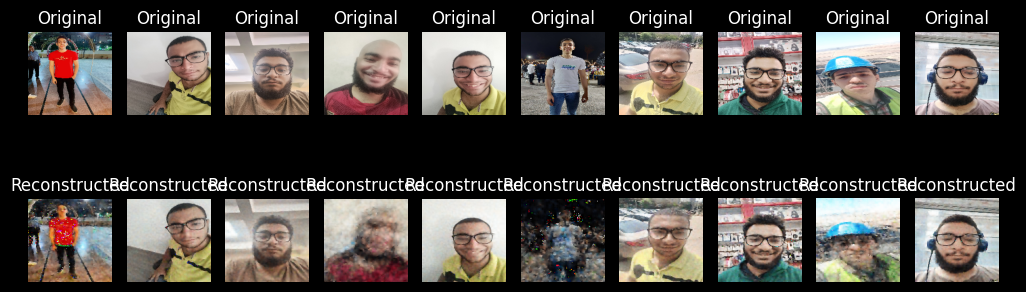

In [170]:
# Load weights from a file
weights_path = 'best_model_weights3.h5'
vae.load_weights(weights_path)
# Plot original and reconstructed images
reconstructed_images = vae.predict(x_test_normalized)
plot_comparison(x_test, reconstructed_images)


51/51 [==============================] - 0s 5ms/step


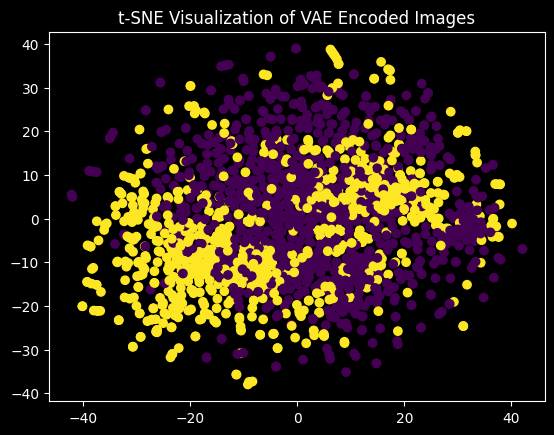

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.models import load_model

# Load weights from a file
weights_path = 'best_model_weights3.h5'
vae.load_weights(weights_path)

# Assuming X_train is your training data (images)
# You may need to preprocess X_train accordingly
encoder = vae.get_layer('encoder')  # Access the decoder layer by its name
# Encode images using the VAE encoder
encoded_images = encoder.predict(x_train)[0]

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_images)

# Scatter plot the t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train, cmap='viridis')  # y_train is the true class labels
plt.title('t-SNE Visualization of VAE Encoded Images')
plt.show()

In [280]:
encoder = vae.get_layer('encoder')  # Access the decoder layer by its name
coded_images = encoder.predict(x_test_normalized)
print(len(coded_images))


1/1 [==============================] - 0s 23ms/step
3


In [281]:
import random
def add_random_numbers(arr,i):
    num_items_to_modify = int(len(arr)*i)
    indices_to_modify = random.sample(range(len(arr)),num_items_to_modify)
    for index in indices_to_modify:
        arr[index]+=random.uniform(-i,i)
    return arr    
    
                                      

1/1 [==============================] - 0s 24ms/step


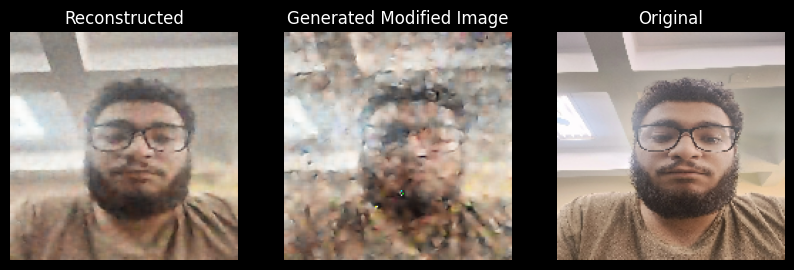

In [286]:
mod_image=add_random_numbers(coded_images[0],0.5)
decoder = vae.get_layer('decoder')
generated_images = decoder.predict(mod_image)


plt.figure(figsize=(10, 5))

# Plot reconstructed images
plt.subplot(1, 3, 1)
plt.imshow((reconstructed_images * 255).astype('uint8'))  
plt.title("Reconstructed")
plt.axis('off')
# Plot generated images
plt.subplot(1, 3, 2)
plt.imshow((generated_images * 255).astype('uint8'))  
plt.title('Generated Modified Image')
plt.axis('off')

# Plot generated images
plt.subplot(1, 3, 3)
plt.imshow(x_test.astype('uint8'))
plt.title("Original")
plt.axis('off')

plt.show()

13/13 [==============================] - 0s 22ms/step


(-0.5, 3199.5, 3199.5, -0.5)

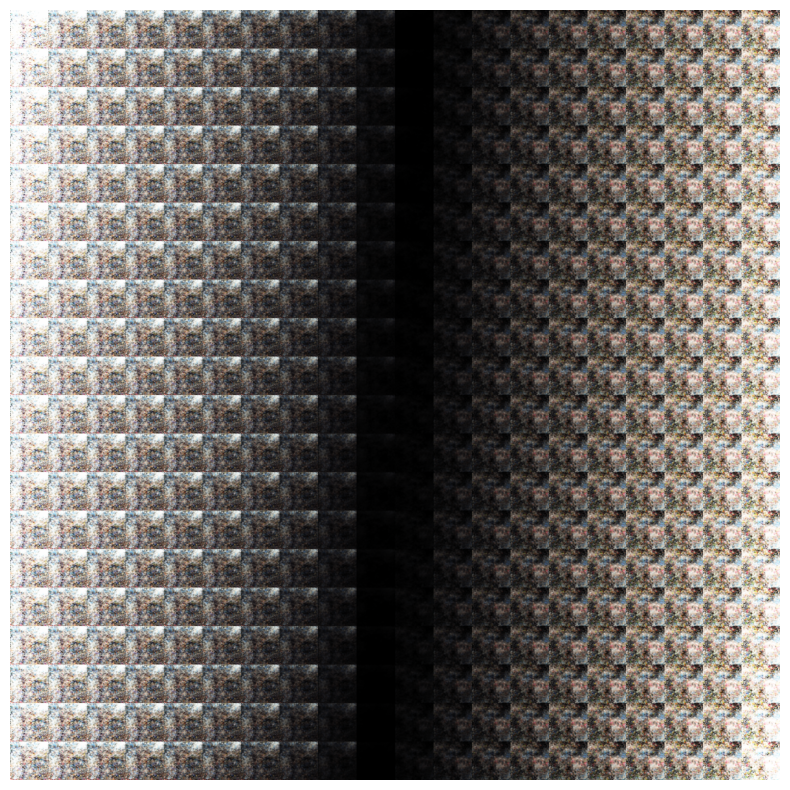

In [133]:
import tensorflow_probability as tfp
import math
# Generate random points in the latent space
# Generate random points in the latent space
# Assuming 'vae' is your trained VAE model
num_samples_to_generate = 400
latent_dim = 1000  # Same as defined earlier for the VAE
width = height = 160

# Generate random points from a standard normal distribution
#random_latent_vectors = np.random.normal(size=(num_samples_to_generate, latent_dim))

norm = tfp.distributions.Normal(0, 1)

# Create a grid in the latent space
random_latent_vectors = np.array([norm.quantile(np.linspace(0.001, 0.999, num_samples_to_generate)) for _ in range(latent_dim)]).T

# Use the decoder part of the trained VAE to generate images from the random latent vectors
decoder = vae.get_layer('decoder')  # Access the decoder layer by its name
generated_images = decoder.predict(random_latent_vectors)

image = np.zeros((math.ceil(math.sqrt(num_samples_to_generate)) * width, math.ceil(math.sqrt(num_samples_to_generate)) * height, 3))

row = 0
col = 0
for i in range(num_samples_to_generate):
    #z = np.array([values])
    #print(z.shape)
    #x_decoded = model.sample(z)
    #print(x_decoded.shape)
    digit = tf.reshape(generated_images[i], (width, height , 3))
    #print(digit)
    #plt.figure(figsize=(25, 25))
    #plt.imshow(digit)
    #plt.axis('Off')
    image[col * width: (col + 1) * width, row * height: (row + 1) * height,:] = digit.numpy()
    col += 1
    if(col >= math.ceil(math.sqrt(num_samples_to_generate))):
        row += 1
        col = 0


# Plot the image array
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='Greys_r')
plt.axis('Off')
# Plot the generated images
#plt.figure(figsize=(12, 6))
#for i in range(num_samples_to_generate):
#    plt.subplot(2, num_samples_to_generate // 2, i + 1)
#    plt.imshow((generated_images[i] * 255).astype('uint8'))  # Adjust pixel values back to 0-255 range
#    plt.axis('off')
#plt.tight_layout()
#plt.show()

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your TensorFlow model
# Example: Save the entire model to a file
vae.save('/kaggle/working/vea_160x160_7800.model')

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
download_file('/kaggle/working/vea_160x160_7800.model', 'vea_160x160_7800.model')